In [1]:
from loguru import logger
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow.data import (
    AUTOTUNE,
    Dataset,
)
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPool2D,
    MaxPooling2D,
    Rescaling,
)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from src import (
    Dataset as WSI_Dataset,
    ModelContext,
    ModelFactory,
)

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"


2024-04-09 17:04:48.689789: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 17:04:48.891463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 17:04:50.619063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-09 17:04:52.659491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:04:

In [2]:
BATCH_SIZE = 4
VALIDATION_SPLIT = 0.2

EPOCHS = 5
LEARNING_RATE = 0.00001
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = SparseCategoricalCrossentropy(from_logits=True)


2024-04-09 17:04:53.619588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:04:53.621570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:04:53.622868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:04:53.811911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:04:53.812754: I external/local_xla/xla/stream_executor

In [3]:
_raw_train_ds, _raw_val_ds, _raw_test_ds = WSI_Dataset.get(validation_split=VALIDATION_SPLIT)

class_names = _raw_train_ds.class_names

logger.info(f"Raw train set with {len(_raw_train_ds)} samples and {len(_raw_train_ds.class_names)} of classes, which are {', '.join(_raw_train_ds.class_names)}")
logger.info(f"Raw validation set with {len(_raw_val_ds)} samples and {len(_raw_val_ds.class_names)} of classes, which are {', '.join(_raw_val_ds.class_names)}")
logger.info(f"Raw test set with {len(_raw_test_ds)} samples and {len(_raw_test_ds.class_names)} of classes, which are {', '.join(_raw_test_ds.class_names)}")


Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1196 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

2024-04-09 17:05:21.852 | INFO     | __main__:<module>:5 - Raw train set with 960 samples and 12 of classes, which are 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9
2024-04-09 17:05:21.857 | INFO     | __main__:<module>:6 - Raw validation set with 240 samples and 12 of classes, which are 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9
2024-04-09 17:05:21.858 | INFO     | __main__:<module>:7 - Raw test set with 1196 samples and 12 of classes, which are 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9
2024-04-09 17:05:21.857 | INFO     | __main__:<module>:6 - Raw validation set with 240 samples and 12 of classes, which are 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9
2024-04-09 17:05:21.858 | INFO     | __main__:<module>:7 - Raw test set with 1196 samples and 12 of classes, which are 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9


In [4]:
def _process_ds(ds: Dataset, batch: int, shuffle: bool) -> Dataset:
    ds = ds.batch(batch)

    if shuffle:
        ds.shuffle(buffer_size=500, reshuffle_each_iteration=True)

    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = _process_ds(_raw_train_ds, batch=BATCH_SIZE, shuffle=True)
val_ds = _process_ds(_raw_val_ds, batch=BATCH_SIZE, shuffle=False)
test_ds = _process_ds(_raw_test_ds, batch=1, shuffle=False)

logger.info(f"Batched train set with {len(train_ds)} samples")
logger.info(f"Batched validation set with {len(val_ds)} samples")
logger.info(f"Test set with {len(test_ds)} samples")


2024-04-09 17:05:22.053 | INFO     | __main__:<module>:13 - Batched train set with 240 samples
2024-04-09 17:05:22.055 | INFO     | __main__:<module>:14 - Batched validation set with 60 samples
2024-04-09 17:05:22.058 | INFO     | __main__:<module>:15 - Test set with 1196 samples
2024-04-09 17:05:22.055 | INFO     | __main__:<module>:14 - Batched validation set with 60 samples
2024-04-09 17:05:22.058 | INFO     | __main__:<module>:15 - Test set with 1196 samples


2024-04-09 17:05:22.484535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-09 17:05:22.493 | DEBUG    | __main__:<module>:28 - Images tensor shape: (12, 200, 200, 3)
2024-04-09 17:05:22.495 | DEBUG    | __main__:<module>:29 - Labels tensor shape: (12,)


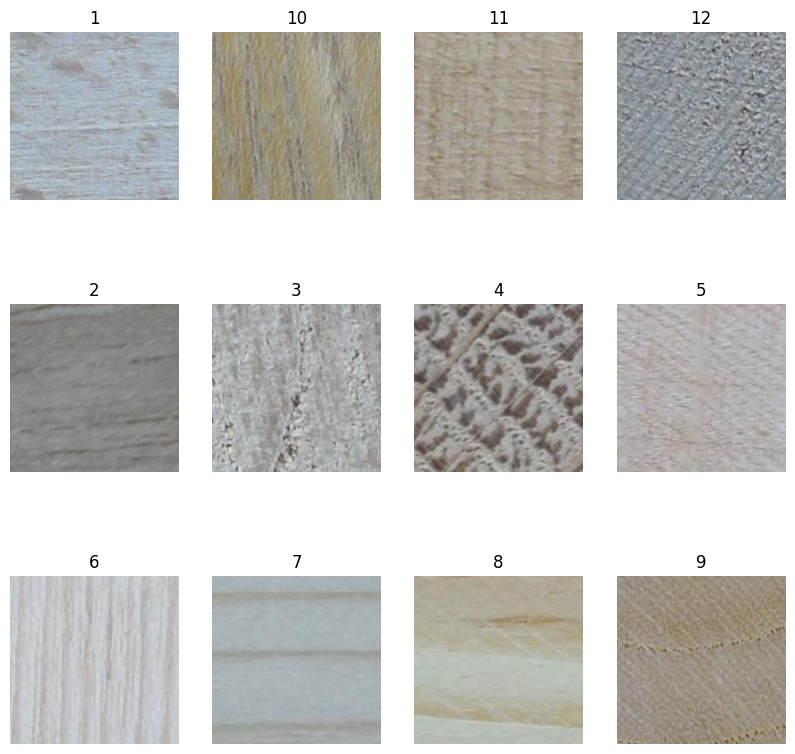

In [5]:

_taken_classes = set()

_images_list = []
_labels_list = []


for images, labels in train_ds:
    for i in range(images.shape[0]):

        if labels[i].numpy() in _taken_classes:
            continue

        _taken_classes.add(labels[i].numpy())

        _images_list.append(images[i])
        _labels_list.append(labels[i])

        if len(_taken_classes) >= len(class_names):
            break

    if len(_taken_classes) >= len(class_names):
        break


_images_tensor = tf.stack(_images_list)
_labels_tensor = tf.stack(_labels_list)

logger.debug(f"Images tensor shape: {_images_tensor.shape}")
logger.debug(f"Labels tensor shape: {_labels_tensor.shape}")


plt.figure(figsize=(10, 10))


for image, label in zip(_images_tensor, _labels_tensor):
    plt.subplot(3, 4, label.numpy() + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")


In [6]:
context: ModelContext = ModelFactory.create(
    Sequential(
        [
            Rescaling(1. / 255),
            Conv2D(32, 3, activation='relu'),
            MaxPooling2D(),
            Conv2D(64, 3, activation='relu'),
            MaxPooling2D(),
            Conv2D(64, 3, activation='relu'),
            MaxPooling2D(),
            Conv2D(128, 3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(len(class_names)),
        ]
    )
)

context.model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS_FUNCTION,
    metrics=["accuracy"],
)

context.model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
context.model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)


Epoch 1/5


I0000 00:00:1712653528.274157   55233 service.cc:145] XLA service 0x7f76b8172360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712653528.274349   55233 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-09 17:05:28.399569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 17:05:28.975485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  7/240 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0271 - loss: 2.4930     

I0000 00:00:1712653537.638300   55233 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.0853 - loss: 2.4838 - val_accuracy: 0.1625 - val_loss: 2.4697
Epoch 2/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1755 - loss: 2.4565 - val_accuracy: 0.1583 - val_loss: 2.4072
Epoch 3/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1869 - loss: 2.3800 - val_accuracy: 0.1625 - val_loss: 2.2975
Epoch 4/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1843 - loss: 2.2663 - val_accuracy: 0.1708 - val_loss: 2.1930
Epoch 5/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1985 - loss: 2.1699 - val_accuracy: 0.1833 - val_loss: 2.1231


1196/1196 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


2024-04-09 17:05:59.599 | DEBUG    | __main__:<module>:6 - Predictions shape: (1196, 12)
2024-04-09 17:05:59.602 | DEBUG    | __main__:<module>:7 - Predictions
[[ 0.87336844 -1.4410243  -0.92506474 ...  0.7704202  -1.4534853
  -0.4288294 ]
 [ 0.48228997 -1.2801945  -0.74107695 ...  0.38620374 -1.1946505
  -0.31831434]
 [ 0.76756865 -1.4697475  -0.90135837 ...  0.68363726 -1.443818
  -0.4250356 ]
 ...
 [ 0.5310986  -1.1783042  -0.66575164 ...  0.47200647 -1.0848076
  -0.2957868 ]
 [ 0.5517684  -1.2600291  -0.70856225 ...  0.4887473  -1.1898738
  -0.32339904]
 [ 0.38974726 -1.1262858  -0.59300834 ...  0.37712872 -1.0036033
  -0.25820664]]
2024-04-09 17:06:00.024109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-09 17:06:00.028 | DEBUG    | __main__:<module>:13 - Actual shape: (1196, 1)
2024-04-09 17:06:00.029 | DEBUG    | __main__:<module>:14 - Actual values
[[ 0]
 [ 0]
 [ 0]
 ...
 [11]
 [11]
 [11]]
20

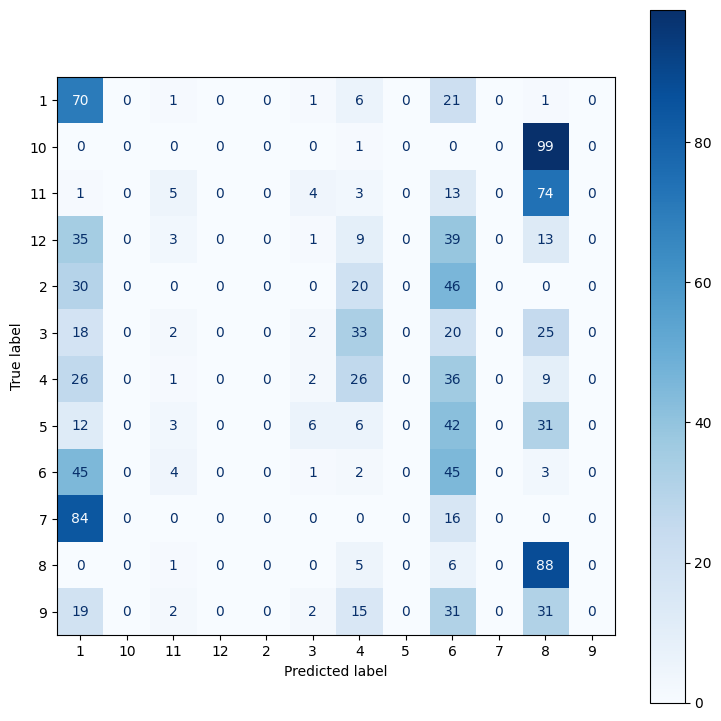

2024-04-09 17:06:00.620 | INFO     | __main__:<module>:38 - Accuracy: 0.19732441471571907
2024-04-09 17:06:00.627 | INFO     | __main__:<module>:39 - Precision: 0.19732441471571907
2024-04-09 17:06:00.627 | INFO     | __main__:<module>:39 - Precision: 0.19732441471571907
2024-04-09 17:06:00.632 | INFO     | __main__:<module>:40 - Sensitivity recall: 0.19732441471571907
/home/kim/.cache/pypoetry/virtualenvs/wood-species-identification-hpklw3A5-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
2024-04-09 17:06:00.641 | INFO     | __main__:<module>:41 - Specificity: 0.19732441471571907
2024-04-09 17:06:00.646 | INFO     | __main__:<module>:42 - F1 score: 0.19732441471571907


In [8]:
predictions = context.model.predict(
    test_ds,
    verbose=1,
)

logger.debug(f"Predictions shape: {predictions.shape}")
logger.debug(f"Predictions\n{predictions}")


actual = np.array([l.numpy() for _, l in test_ds])
predicted = np.argmax(predictions, axis=-1)

logger.debug(f"Actual shape: {actual.shape}")
logger.debug(f"Actual values\n{actual}")

logger.debug(f"Predicted shape: {predicted.shape}")
logger.debug(f"Predicted values\n{predicted}")


cm = confusion_matrix(actual, predicted)

logger.debug(f"Confusion Matrix\n{cm}")


cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names,
)

cm_display.plot(
    cmap="Blues",
    ax=plt.subplots(figsize=(9, 9))[1]
)

plt.show()


logger.info(f"Accuracy: {accuracy_score(actual, predicted)}")
logger.info(f"Precision: {precision_score(actual, predicted, average='micro')}")
logger.info(f"Sensitivity recall: {recall_score(actual, predicted, average='micro')}")
logger.info(f"Specificity: {recall_score(actual, predicted, pos_label=0, average='micro')}")
logger.info(f"F1 score: {f1_score(actual, predicted, average='micro')}")


In [9]:
context.model.summary()
context.save()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,325,030 (39.39 MB)

 Trainable params: 3,441,676 (13.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,883,354 (26.26 MB)

2024-04-09 17:06:01.261 | DEBUG    | src._model:save:31 - Model saved to /home/kim/wood-species-identification/models/sequential-4883f1.keras
